In [32]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_community.tools import TavilySearchResults
from langchain_community.agent_toolkits import create_sql_agent, SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings
from pinecone import Pinecone, ServerlessSpec
from langchain_openai import OpenAIEmbeddings
from langchain.agents import AgentType, initialize_agent
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool

import os

In [13]:
# Initialize model
model = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")


In [14]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


In [15]:
from langchain_core.tools import tool


pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

index = pc.Index('agent-hackathon')
vector_store = PineconeVectorStore(embedding=embeddings, index=index)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [ ]:
db = SQLDatabase.from_uri("sqlite:///db/product_demo.db")


In [ ]:
sql_toolkit = SQLDatabaseToolkit(db=db, llm=model)

web_search = TavilySearchResults(
        max_results=5,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=True,
        include_images=False,
        # include_domains=[...],
        # exclude_domains=[...],
        # name="...",            # overwrite default tool name
        # description="...",     # overwrite default tool description
        # args_schema=...,       # overwrite default args_schema: BaseModel
    )

yh_tools = [YahooFinanceNewsTool()]

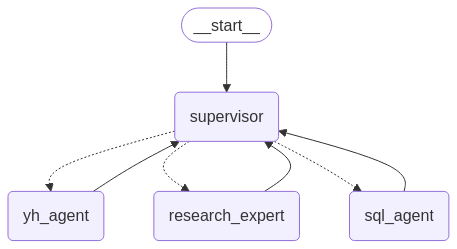

In [30]:
research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")  
system_message = prompt_template.format(dialect="SQLite", top_k=5) 

sql_agent = create_react_agent(
    model=model, 
    name='sql_agent',
    tools=sql_toolkit.get_tools(),
    prompt=system_message
)

rag_agent = create_react_agent(model, [retrieve], name="rag_agent")

yh_agent = create_react_agent(
    name="yh_agent",
    model=model,
    tools=yh_tools,
)


# Create supervisor workflow
workflow = create_supervisor(
    [research_agent, sql_agent, yh_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a research expert and a sql expert connected to a product database and a rag agent that has information on an article LLM Powered Autonomous Agents."
        "For current events, use research_agent. "
        "For learning about products from database use sql_agent."
        "For questions on the LLM Powered Autonomous Agents paper use rag_agent."
    )
)

app = workflow.compile()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [21]:
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "What is the standard method for Task Decomposition based on the LLM Powered Autonomous Agents paper? vs what's on the internet?"
        }
    ]
})

In [22]:
result

{'messages': [HumanMessage(content="What is the standard method for Task Decomposition based on the LLM Powered Autonomous Agents paper? vs what's on the internet?", additional_kwargs={}, response_metadata={}, id='41ff5f88-16c3-44f2-acc0-00ad1fe794c2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Lb5iHCrHZw9h2q01yqn5mNhp', 'function': {'arguments': '{}', 'name': 'transfer_to_rag_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 163, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run-898421fd-49b9-41bb-a6f6-0a8f6a31d22b-0', tool_calls=[{'name': 'transfer_to_ra